# **Discovering Gaussian Parameters**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **Extended learning and understanding by VigyannVeshi**


In [1]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

# import summary libraries for model information
from torchsummary import summary

# import dataset/loader libraries
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
# use GPU if available
device = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [32]:
# Creating Gaussian Blurs with different widths
nGauss=2000
imgSize=91

x=np.linspace(-4,4,imgSize) 
X,Y=np.meshgrid(x,x)


# initialize tensors containing images and labels
images=tr.zeros(nGauss,1,imgSize,imgSize)
labels=tr.zeros(nGauss,3)

for i in range(nGauss):

    # create the gaussian with random centers
    loc=np.max(x)/2*np.random.randn(2) # ro-> random offset
    wid=np.random.rand()*10+5

    
    # create gaussian and add noise
    G=np.exp(-((X-loc[0])**2+(Y-loc[1])**2)/(wid))
    G=G+np.random.randn(imgSize,imgSize)/10
    ### Additional explorations 1) increasing noise
    # G=G+np.random.randn(imgSize,imgSize)/1.2

    # add to tensor
    images[i,:,:,:]=tr.Tensor(G).view(1,imgSize,imgSize)
    labels[i,:]=tr.Tensor([loc[0],loc[1],wid])

print(labels.shape)
print(images.shape)

torch.Size([2000, 3])
torch.Size([2000, 1, 91, 91])


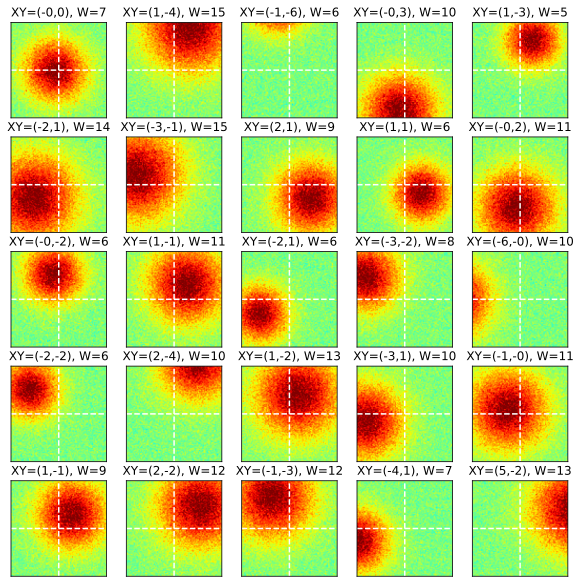

In [33]:
# visualize some images
fig,axs=plt.subplots(5,5,figsize=(10,10))

for i,ax in enumerate(axs.flatten()):
    whichpic=np.random.randint(nGauss)
    G=np.squeeze(images[whichpic,:,:])
    ax.imshow(G,vmin=-1,vmax=1,cmap="jet",extent=[-4,4,-4,4],origin='upper')
    ax.set_title(f'XY=({labels[whichpic,0]:.0f},{labels[whichpic,1]:.0f}), W={labels[whichpic,2]:.0f}')
    ax.plot([-4,4],[0,0],'w--')
    ax.plot([0,0],[-4,4],'w--')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

**Additional Exploration 1) Increasing Noise**

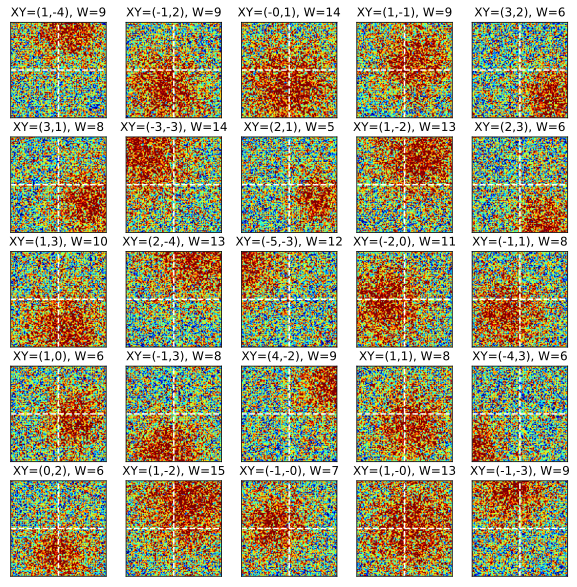

In [4]:
# visualize some images
fig,axs=plt.subplots(5,5,figsize=(10,10))

for i,ax in enumerate(axs.flatten()):
    whichpic=np.random.randint(nGauss)
    G=np.squeeze(images[whichpic,:,:])
    ax.imshow(G,vmin=-1,vmax=1,cmap="jet",extent=[-4,4,-4,4],origin='upper')
    ax.set_title(f'XY=({labels[whichpic,0]:.0f},{labels[whichpic,1]:.0f}), W={labels[whichpic,2]:.0f}')
    ax.plot([-4,4],[0,0],'w--')
    ax.plot([0,0],[-4,4],'w--')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [34]:
# Create train/test groups using Dataloader

# step 2: use scikit-learn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(images,labels,test_size=0.1)

# step 3: convert to Pytorch Datasets
train_data=TensorDataset(train_data,train_labels)
test_data= TensorDataset(test_data,test_labels)

# step 4: translate into dataloader objects
batchsize=16
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [35]:
# check size (should be images x channels x width x height)
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 3])


In [7]:
def outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,outChannels):
    Nh=int(np.floor((imgSize[0]+2*paddingSize[0]-kernelSize[0])/strideSize[0]))+1
    Nw=int(np.floor((imgSize[1]+2*paddingSize[1]-kernelSize[1])/strideSize[1]))+1
    return outChannels,(Nh,Nw),(int(Nh//poolSize[0]),int(Nw//poolSize[1]))

def fcInput(imgSize,inChannels):
    return int(imgSize[0]*imgSize[1]*inChannels)

In [8]:
# Create the DL model
def createNet(lr=0.001):
    input_img_channels=1
    convOutChannels=[6,4]
    imgSize=(91,91)
    kernelSize=(3,3)
    strideSize=(1,1)
    paddingSize=(1,1)
    poolSize=(2,2)
    fc1_nodes=50

    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### ENCODER: 

            # conv 1
            ### inChannels, outChannel, kernelSize, strideSize, paddingSize
            self.conv1=nn.Conv2d(input_img_channels,convOutChannels[0],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.outcp1=outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,convOutChannels[0])
            
            # conv 2
            self.conv2=nn.Conv2d(convOutChannels[0],convOutChannels[1],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.outcp2=outConvPoolSize(self.outcp1[2],kernelSize,strideSize,paddingSize,poolSize,convOutChannels[1])

            # fc1
            self.fci=fcInput(self.outcp2[2],self.outcp2[0])
            self.fc1=nn.Linear(self.fci,fc1_nodes)

            # output
            self.output=nn.Linear(fc1_nodes,3)

        def forward(self,x):
            # first conv-pool set
            conv1act=F.relu(self.conv1(x))  
            x=F.avg_pool2d(conv1act,poolSize)

            # second conv-pool set
            conv2act=F.relu(self.conv2(x))  
            x=F.avg_pool2d(conv2act,poolSize)
            
            # FNN part
            x=x.reshape(x.shape[0],-1)
            x=F.relu(self.fc1(x))
            x=self.output(x)

            return x

    # create the model instance
    net=GaussNet()

    # loss function
    lossfun=nn.MSELoss()

    # optimizer
    optimizer = tr.optim.Adam(net.parameters(),lr=lr)

    return net,lossfun,optimizer

In [9]:
# test the model with one batch
net,lossfun,optimizer=createNet()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print(yHat)
print(' ')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

tensor([[ 0.0741, -0.1700,  0.0351],
        [ 0.0757, -0.1423,  0.0465],
        [ 0.0821, -0.1442,  0.0637],
        [ 0.0835, -0.1612,  0.0441],
        [ 0.0849, -0.1813,  0.0365],
        [ 0.0722, -0.1396,  0.0716],
        [ 0.0770, -0.1616,  0.0549],
        [ 0.0737, -0.1731,  0.0447],
        [ 0.0664, -0.1731,  0.0449],
        [ 0.0701, -0.1528,  0.0533],
        [ 0.0949, -0.1588,  0.0330],
        [ 0.0806, -0.1786,  0.0397],
        [ 0.0686, -0.1983,  0.0359],
        [ 0.0842, -0.1457,  0.0415],
        [ 0.0481, -0.2118,  0.0389],
        [ 0.0767, -0.1722,  0.0224]], grad_fn=<AddmmBackward0>)
 
torch.Size([16, 3])
 
Loss:
tensor(30.8409, grad_fn=<MseLossBackward0>)


In [10]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
            Conv2d-2            [-1, 4, 45, 45]             220
            Linear-3                   [-1, 50]          96,850
            Linear-4                    [-1, 3]             153
Total params: 97,283
Trainable params: 97,283
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [11]:
# Create a function that trains the model

def trainModel(n_epochs=30):
    # create a new model
    net,lossfun,optimizer=createNet()

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = tr.zeros(n_epochs)
    testLoss = tr.zeros(n_epochs)

    # loop over epochs
    for epochi in range(n_epochs):

        # loop over training data batches
        batchLoss=[]

        for X,y in train_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat=net(X)
            loss=lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # end of batch loop ...

        # and get the average losses across the batches
        trainLoss[epochi]=np.mean(batchLoss)

        # test accuracy
        X,y=next(iter(test_loader))
        # push data to GPU
        X = X.to(device)
        y = y.to(device)
        with tr.no_grad(): # deactivates autograd
            yHat=net(X)
            loss=lossfun(yHat,y)

        # compare the following really long lines of code to the training accuracy lines
        testLoss[epochi]=loss.item()

        print(f"{epochi+1}/{n_epochs} complete!")
    # end of epochs

    # function output
    return trainLoss,testLoss,net

In [36]:
# Run the model and show the results
trainLoss,testLoss,net=trainModel()

1/30 complete!
2/30 complete!
3/30 complete!
4/30 complete!
5/30 complete!
6/30 complete!
7/30 complete!
8/30 complete!
9/30 complete!
10/30 complete!
11/30 complete!
12/30 complete!
13/30 complete!
14/30 complete!
15/30 complete!
16/30 complete!
17/30 complete!
18/30 complete!
19/30 complete!
20/30 complete!
21/30 complete!
22/30 complete!
23/30 complete!
24/30 complete!
25/30 complete!
26/30 complete!
27/30 complete!
28/30 complete!
29/30 complete!
30/30 complete!


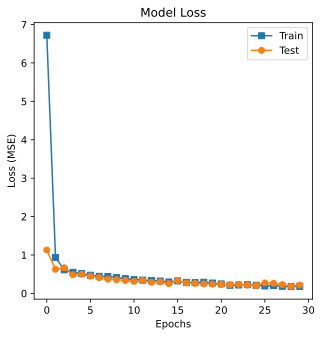

In [37]:
fig,ax=plt.subplots(1,1,figsize=(5,5))

ax.plot(trainLoss,'s-',label="Train")
ax.plot(testLoss,'o-',label="Test")
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Model Loss')
ax.legend()
plt.show()

**Additional Exploration 1) Increasing Noise**

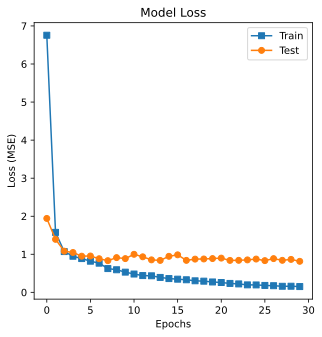

In [13]:
fig,ax=plt.subplots(1,1,figsize=(5,5))

ax.plot(trainLoss,'s-',label="Train")
ax.plot(testLoss,'o-',label="Test")
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Model Loss')
ax.legend()
plt.show()

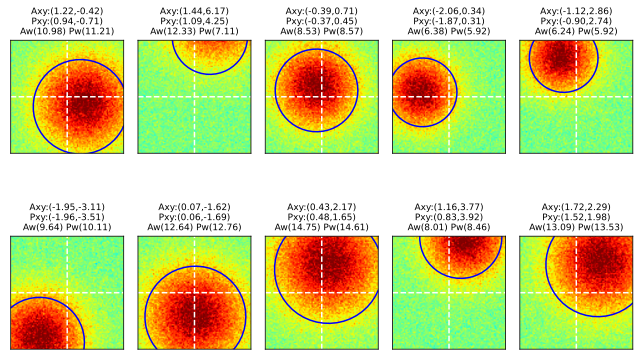

In [38]:
# visualize some images
X,Y = next(iter(test_loader))
# for GPU
X = X.to(device)
net.to(device)
yHat=net(X)

# Getting Data back  to CPU
yHat=yHat.to('cpu')
X=X.to('cpu')

fig,axs=plt.subplots(2,5,figsize=(9,6))

th=np.linspace(0,2*np.pi)

for i,ax in enumerate(axs.flatten()):
    # get the gaussian and draw it, and draw the white guide-lines
    G=tr.squeeze(X[i,0,:,:]).detach()
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='lower')
    ax.plot([-4,4],[0,0],'w--')
    ax.plot([0,0],[-4,4],'w--')
    ax.set_title(f'Axy:({Y[i][0]:.2f},{Y[i][1]:.2f})\nPxy:({yHat[i][0]:.2f},{yHat[i][1]:.2f})\nAw({Y[i][-1]:.2f}) Pw({yHat[i][-1]:.2f})',fontsize=9)

    # compute the model's prediction
    cx=yHat[i][0].item()    # center x
    cy=yHat[i][1].item()    # center y
    rd=yHat[i][2].item()    # radius

    # and draw it
    x=cx+np.cos(th)*np.sqrt(rd)
    y=cy+np.sin(th)*np.sqrt(rd)
    ax.plot(x,y,'b')

    # and some final plotting niceties
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])


plt.tight_layout()
plt.show()

**Additional Exploration: 1) Increasing noise**

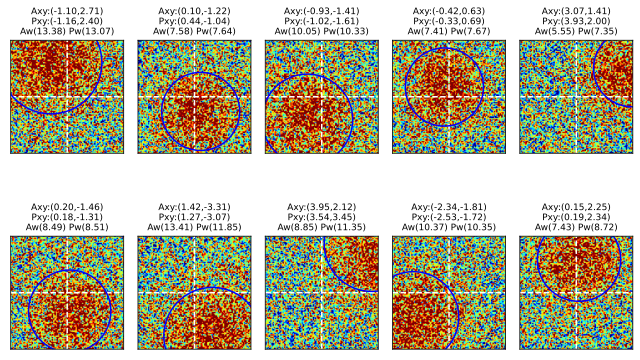

In [14]:
# visualize some images
X,Y = next(iter(test_loader))
# for GPU
X = X.to(device)
net.to(device)
yHat=net(X)

# Getting Data back  to CPU
yHat=yHat.to('cpu')
X=X.to('cpu')

fig,axs=plt.subplots(2,5,figsize=(9,6))

th=np.linspace(0,2*np.pi)

for i,ax in enumerate(axs.flatten()):
    # get the gaussian and draw it, and draw the white guide-lines
    G=tr.squeeze(X[i,0,:,:]).detach()
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='lower')
    ax.plot([-4,4],[0,0],'w--')
    ax.plot([0,0],[-4,4],'w--')
    ax.set_title(f'Axy:({Y[i][0]:.2f},{Y[i][1]:.2f})\nPxy:({yHat[i][0]:.2f},{yHat[i][1]:.2f})\nAw({Y[i][-1]:.2f}) Pw({yHat[i][-1]:.2f})',fontsize=9)

    # compute the model's prediction
    cx=yHat[i][0].item()    # center x
    cy=yHat[i][1].item()    # center y
    rd=yHat[i][2].item()    # radius

    # and draw it
    x=cx+np.cos(th)*np.sqrt(rd)
    y=cy+np.sin(th)*np.sqrt(rd)
    ax.plot(x,y,'b')

    # and some final plotting niceties
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])


plt.tight_layout()
plt.show()

In [30]:
# understanding  the use of np.corrcoef
rx=np.corrcoef(Y[:,0].detach(),yHa# With high gaussian noise
fig=plt.figure(figsize=(5,5))

for i in range(3):
    plt.plot(Y[:,i].detach(),yHat[:,i].detach(),'o')

rx=np.corrcoef(Y[:,0].detach(),yHat[:,0].detach())[0][1]
ry=np.corrcoef(Y[:,1].detach(),yHat[:,1].detach())[0][1]
rw=np.corrcoef(Y[:,2].detach(),yHat[:,2].detach())[0][1]
plt.title(f"Correlation Coefficients: $r_x$={rx}, $r_y$={ry}, $r_w$={rw}")
plt.legend(['x','y','r'])
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()t[:,0].detach())[0][1]
rx

0.9801334910462007

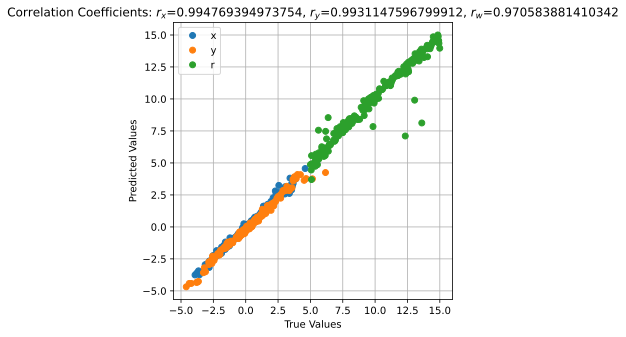

In [39]:
fig=plt.figure(figsize=(5,5))

for i in range(3):
    plt.plot(Y[:,i].detach(),yHat[:,i].detach(),'o')

rx=np.corrcoef(Y[:,0].detach(),yHat[:,0].detach())[0][1]
ry=np.corrcoef(Y[:,1].detach(),yHat[:,1].detach())[0][1]
rw=np.corrcoef(Y[:,2].detach(),yHat[:,2].detach())[0][1]
plt.title(f"Correlation Coefficients: $r_x$={rx}, $r_y$={ry}, $r_w$={rw}")
plt.legend(['x','y','r'])
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

**Additional Exploration: 1) Increasing noise**

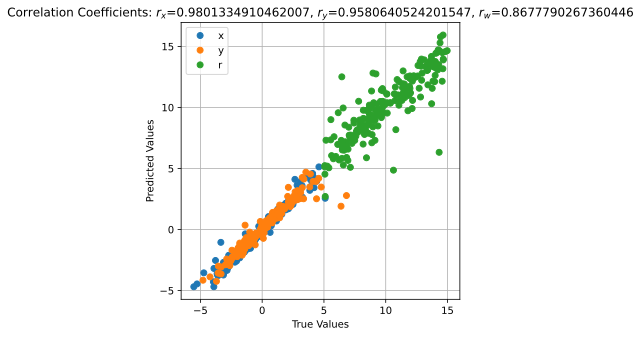

In [31]:
# With high gaussian noise
fig=plt.figure(figsize=(5,5))

for i in range(3):
    plt.plot(Y[:,i].detach(),yHat[:,i].detach(),'o')

rx=np.corrcoef(Y[:,0].detach(),yHat[:,0].detach())[0][1]
ry=np.corrcoef(Y[:,1].detach(),yHat[:,1].detach())[0][1]
rw=np.corrcoef(Y[:,2].detach(),yHat[:,2].detach())[0][1]
plt.title(f"Correlation Coefficients: $r_x$={rx}, $r_y$={ry}, $r_w$={rw}")
plt.legend(['x','y','r'])
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

**Additional Explorations**

In [40]:
# 1) Is this model robust to noise? Explore this by increasing the amount of noise added to each stimulus. You can set this up as a parametric experiment if you want, but you can also do it informally, by changing the gain factor of the noise to see whether performance noticeably declines when the images get noisier. Does changing the noise affect the center coordinates or the width more? And what do the results tell you about the power -- or limitations -- of using CNNs for finding features in images?
# --> On increasing Gaussian noise content the width is affected more (check the notebook above)

# 2) You can see from the code that I didn't change the model architecture -- I literally copy/pasted it from the previous Gaussian codes and only added 3 units at the end. Do you think you can develop a different architecture, possibly simpler, that achieves comparable performance while reducing learning time?
# --> This is what I have set to explore!